- ID : 고객ID
- Age : 고객나이
- Experience : 직장 경험
- Income : 수입액
- ZIP Code : 우편번호
- Family : 가족수
- CCAvg : 월평균카드 사용액
- Education : 학력
- Mortgage : 주택담보 대출 금액
- Personal Loan : 개인대출 전환여부
- Securities Account : 보험 유무
- CD Account : 양도성 예금 증서 보유 여부
- Online : 온라인 뱅킹 사용 여부
- CreditCard : 신용카드 보유 여부

In [ ]:
!pip install optuna

In [ ]:
import gdown
import pandas as pd
import numpy as np

import requests
from bs4 import BeautifulSoup

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
import lightgbm as lgb
import xgboost as xgb
import optuna
import pickle
import shap

In [ ]:
# 웹 데이터 수집
web_site = 'https://github.com/trex99/fintech/blob/main/train.csv?plain=1'

# 웹 사이트 접속
url = requests.get(web_site)
# 웹 페이지 분석
soup = BeautifulSoup(url.content.decode('utf-8'), 'html.parser')
# 필요정보 선택
data = soup.find_all('div','react-code-text react-code-line-contents')

In [ ]:
# 데이터 저장
a = []
for i in range(len(data)):
  a.append(data[i].text)
  df = pd.DataFrame(a, columns=['data'])
# , 기준으로 문자 분리
for i in range(len(df)):
  for j in range(len(df.columns)):
    df.iloc[i] = df.iloc[i].str.split(",")
# 저장할 새로운 df 생성 및 저장
col = df['data'][0]
df1 = pd.DataFrame(df.iloc[1:], columns=col, index = range(len(df)-1))
for i in range(len(df1)):
  for j in range(len(col)):
    df1.iloc[i,j] = df['data'][i+1][j]

In [ ]:
# 결측값 확인
df1.isnull().sum()

In [ ]:
# 데이터 숫자형으로 변경
df_int = df1.drop(columns=['CCAvg'],axis = 1)
df_float = df1[['CCAvg']]
df_int = df_int.astype(int)
df_float = df_float.astype(float)
train = pd.concat([df_int,df_float], axis =1)

# 데이터 확인


In [ ]:
# 데이터 정보 확인
train.describe().T

In [ ]:
# 직장경험 데이터 확인
train['Experience'].value_counts().sort_index()

In [ ]:
# 나이 데이터 확인
train['Age'].value_counts().sort_index()

In [ ]:
# 수입액 확인
train['Income'].value_counts().sort_index()

In [ ]:
# 우편번호 확인
train['ZIP Code'].value_counts().sort_index()

In [ ]:
# 가족수 확인
train['Family'].value_counts().sort_index()

In [ ]:
# 월평균카드 사용액 확인
train['CCAvg'].value_counts().sort_index()

In [ ]:
# 학력 확인
train['Education'].value_counts().sort_index()

In [ ]:
# 주택담보 대출 금액 확인
train['Mortgage'].value_counts().sort_index()

In [ ]:
# 보험유무 확인
train['Securities Account'].value_counts().sort_index()

In [ ]:
# 양도성 예금 증서 보유 여부 확인
train['CD Account'].value_counts().sort_index()

In [ ]:
# 온라인 뱅킹 사용 여부 확인
train['Online'].value_counts().sort_index()

In [ ]:
# 개인대출 전환 여부 확인
train['Personal Loan'].value_counts().sort_index()

In [ ]:
# 개인대출 전환 여부별 변수들의 평균값 확인
col = train.columns
train.groupby('Personal Loan')[col].mean()

# 전처리

In [ ]:
# 이상치 제거
train.drop(train[train['Experience'] < 0].index, inplace=True)
train.drop(train[train['ZIP Code'] < 90000].index, inplace=True)

In [ ]:
# 평균 수입액과 자신의 수입액의 차이
train['Difference'] = train['Income'] - train['Income'].mean()
# 저축액
train['Saving'] = train['Income'] - train['CCAvg']
# 저축액 대비 주택담보대출금액
train['Mortgage/Saving'] = train['Mortgage']/train['Saving']

In [ ]:
# train data 정규화
x = train.drop(['Personal Loan','ID'], axis = 1)
y = train['Personal Loan']
sc = StandardScaler()
x = pd.DataFrame(sc.fit_transform(x), columns = x.columns)

In [ ]:
# 학습 데이터 분리
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3, random_state = 42)

# LGBM 모델 생성 및 학습

In [ ]:
# lgbm 튜닝 객체 생성
def model_tuner_lgbm(trial, x_train,x_test,y_train,y_test):
  params = {
      'n_estimators' : trial.suggest_int('n_estimators',500,3000),
      'learning_rate' : trial.suggest_float('learning_rate',0.01,0.1),
      'num_leaves' : trial.suggest_int('num_leaves',5,30)
  }
  # 모델 생성 및 학습
  model = lgb.LGBMClassifier(**params, random_state=42, objective='binary', verbosity = -1)
  model.fit(x_train,y_train,eval_set=[(x_test,y_test)])
  # 모델 예측 및 성능 평가
  y_pred = model.predict(x_test)
  score = roc_auc_score(y_test,y_pred)
  return score

In [ ]:
# optuna_lgbm 튜닝
op = optuna.create_study(sampler=optuna.samplers.TPESampler(), direction = 'maximize')
op.optimize(lambda trial: model_tuner_lgbm(trial, x_train,x_test,y_train,y_test), n_trials = 200)
print('best_param :', op.best_trial.params, 'best_score :', op.best_trial.value)

In [ ]:
# op의 best_param으로 lgbm_model 생성
best_model_lgbm = lgb.LGBMClassifier(**op.best_trial.params, random_state = 42, objective = 'binary', vervosity = -1)
best_model_lgbm.fit(x_train,y_train,eval_set=[(x_test,y_test)])
y_pred_lgbm = best_model_lgbm.predict(x_test)
score_lgbm = roc_auc_score(y_test,y_pred_lgbm)
print('best_param :', op.best_trial.params, 'best_score :', score_lgbm)

# XGBoost 모델 생성

In [ ]:
# XGBoost 튜닝 객체 생성
def model_tuner_xgb(trial, x_train, x_test, y_train, y_test):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 3000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'gamma': trial.suggest_int('gamma', 0, 10),
        'reg_lambda': trial.suggest_int('reg_lambda', 0, 10),
        'reg_alpha': trial.suggest_int('reg_alpha', 0, 10),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'verbosity': 0,
    }

    # 모델 생성 및 학습
    model = xgb.XGBClassifier(**params, random_state=42, objective='binary:logistic')
    model.fit(x_train, y_train, eval_set=[(x_test, y_test)], verbose=False)

    # 모델 예측 및 성능 평가
    y_pred = model.predict(x_test)
    score = roc_auc_score(y_test, y_pred)
    return score

In [ ]:
# optuna_xgb 튜닝
op_xgb = optuna.create_study(sampler=optuna.samplers.TPESampler(), direction = 'maximize')
op_xgb.optimize(lambda trial: model_tuner_xgb(trial, x_train,x_test,y_train,y_test), n_trials = 150)
print('best_param :', op_xgb.best_trial.params, 'best_score :', op_xgb.best_trial.value)

In [ ]:
# op의 best_param으로 xgb_model 생성
best_model_xgb = xgb.XGBClassifier(**op_xgb.best_trial.params, random_state = 42, objective = 'binary:logistic')
best_model_xgb.fit(x_train,y_train,eval_set=[(x_test,y_test)], verbose=False)
y_pred_xgb = best_model_xgb.predict(x_test)
score_xgb = roc_auc_score(y_test,y_pred_xgb)
print('best_param :', op_xgb.best_trial.params, 'best_score :', score_xgb)

In [ ]:
# k-fold 교차검증 실행
cvs = cross_val_score(estimator= best_model_xgb, X=x_test, y= y_test, scoring='roc_auc_ovr',cv=5)
cvs.mean()

# 변수 중요도 확인

<Axes: >

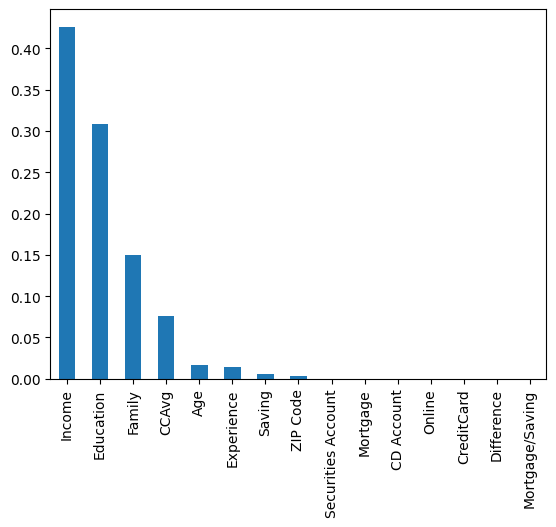

In [ ]:
# 중요 변수 확인
val_imp = pd.DataFrame(model.feature_importances_, index = model.feature_names_in_, columns = ['imp'])
val_imp['imp'].sort_values(ascending=False).plot(kind='bar')

In [ ]:
# 개인 대출 전환여부에 높은 영향 끼친 변수 TOP5
val_imp2 = val_imp[val_imp['imp'] > 0]
val = val_imp2['imp'].sort_values(ascending=False)[:5]
val

,imp
Income,0.426355
Education,0.308505
Family,0.149842
CCAvg,0.076371
Age,0.016562


,0
Income,-1.248522
CCAvg,-0.419324
Family,-0.067988
Education,-0.054641
Age,-0.016343


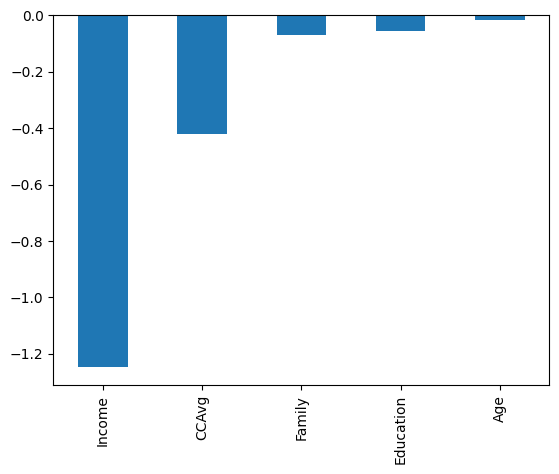

In [ ]:
# feature값이 targetd 어떤(양 or 음) 영향을 주는지 확인
# SHAP Explainer 생성
explainer = shap.Explainer(model)
shap_values = explainer(x)
# SHAP 값을 DataFrame으로 변환
shap_df = pd.DataFrame(shap_values.values, columns=x.columns)
# 각 변수의 평균 SHAP 값 계산
shap_mean = shap_df.mean().sort_values(ascending=True)
shap_mean[[0,1,2,3,5]].plot(kind='bar')
shap_mean[[0,1,2,3,5]]
# target을 결정하는데 중요했던 상위 5개의 변수 모두 음의 영향을 준다.

개인대출 전환 여부를 예측하는데 중요한 변수는 다음의 순위와 같다.

1. Income(수입)
2. Education(학력)
3. Family(가족수)
4. CCAvg(월평균 카드 사용액 평균)
5. Age(나이)

위의 변수들의 값이 증가하면 개인대출로 전환되지 않을 확률이 높다.

그러니 수입과 학력, 월평균 카드 사용액 평균이 낮고 나이와 가족 수가 적은 사람을 노려서 마케팅하는 것이 좋을 것으로 판단된다